# Mapping scRNAseq to 2D space

The aim is to spatially map single cell RNA-seq (scRNAseq) to a 2D spatial plane such that the cells are spatially arranged similar to how they would be structured in-vivo. 

**This is done without prior knowledge of cell locations for the scRNAseq cells.**

The training set would include all information from a Spatial Transcriptomic (ST) measurement, including gene expression per spatial coordinate overlayed on histology pixels.

ST data from the Allen Brain Institute is used from:

https://github.com/almaan/spacetx/

This is purposed for the Competition from the Allen Brain Institute:

https://labshare.cshl.edu/shares/gillislab/resource/CellTypeMapping_2022/


Able to run on 16 vCPUs, 128 GB RAM
with PyTorch 1.11 (with Intel® MKL-DNN/MKL)


In [1]:
# !wget https://labshare.cshl.edu/shares/gillislab/resource/CellTypeMapping_2022/challenge2/barseq2.hdf5
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-1.h5ad.gz
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-2.h5ad.gz
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-3.h5ad.gz
# !wget https://github.com/almaan/spacetx/raw/master/data/Allen-4.h5ad.gz

# !gunzip Allen-1.h5ad.gz
# !gunzip Allen-2.h5ad.gz
# !gunzip Allen-3.h5ad.gz
# !gunzip Allen-4.h5ad.gz


In [2]:
import h5py
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch.nn as nn
import gc
import scanpy as sc
from scipy import ndimage
import random
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import leidenalg
import scanorama
import anndata as AnnData
import scvi


Global seed set to 0


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

seed_num = 1
np.random.seed(seed_num)
random.seed(seed_num)
torch.manual_seed(seed_num)


In [4]:
window_size = 2
main_axis_size = 800

# Generate a uniform grid of M cells
def to_grid(M):
    grid = np.random.uniform(size=(M.shape[1],2))
    return grid

# Put gene expression as new "channels" on top of uniform grid
def to_kde_grid(M,grid,main_axis_size=main_axis_size,window_size=window_size):
    main_grid = np.zeros(((main_axis_size+4*window_size),(main_axis_size+4*window_size),M.shape[0]))
    for i in range(M.shape[0]):
        x = np.round(main_axis_size*grid[:,0],0).astype(np.int)+2*window_size
        y = np.round(main_axis_size*grid[:,1],0).astype(np.int)+2*window_size
        main_grid[x,y,i] = main_grid[x,y,i]+M[i,:].reshape([M.shape[1],])
        main_grid[:,:,i] = ndimage.gaussian_filter(main_grid[:,:,i], window_size)
    return main_grid

# Get KNN gene expression "convolutions" from gene expression "channels"
def to_samples(kde_grid,grid,w_size=window_size,type_data="numpy",modality="ST"):
    W,H,C = kde_grid.shape
    if modality=="ST":
        x = grid[:,0].astype(np.int)
        y = grid[:,1].astype(np.int)
    else:
        x = np.round(main_axis_size*grid[:,0],0).astype(np.int)+2*window_size
        y = np.round(main_axis_size*grid[:,1],0).astype(np.int)+2*window_size
    
    main_kde_conv = np.zeros((len(x),w_size*2*w_size*2*C))
    for i in range(len(x)):
        main_kde_conv[i,:] = (kde_grid[(x[i]-w_size):(x[i]+w_size),(y[i]-w_size):(y[i]+w_size),:]).reshape([1,w_size*2*w_size*2*C])

    if type_data == "tensor":
        main_kde_conv = torch.from_numpy(main_kde_conv).float().to(device)
        
    return main_kde_conv



In [5]:

# Read in Allen Brain data
allen_1 = sc.read_h5ad("Allen-1.h5ad")
allen_2 = sc.read_h5ad("Allen-2.h5ad")
allen_3 = sc.read_h5ad("Allen-3.h5ad")
allen_4 = sc.read_h5ad("Allen-4.h5ad")



# Read in Competition data
import h5py
from scipy import sparse
with h5py.File('barseq2.hdf5') as f:
    dim = f['dim'][()]
    genes_old = [g.decode('utf-8') for g in f['dimnames/genes'][()]]
    cells = [c.decode('utf-8') for c in f['dimnames/cells'][()]]
    i = f['matrix/i'][()] - 1
    j = f['matrix/j'][()] - 1  
    x = f['matrix/x'][()]
    M = sparse.csc_matrix((x, (i,j)) , shape =dim )

M = M.todense()

# Select similar genes shared between datasets
genes = [i for i in genes_old if i not in ['Tafa1', 'Tafa2', 'Ccn2']]
allen_1_select = allen_1[:,genes]
allen_2_select = allen_2[:,genes]
allen_3_select = allen_3[:,genes]
allen_4_select = allen_4[:,genes]

M = M[np.where(np.asarray([i in genes for i in genes_old]))[0],:]


In [6]:
genes

['Calb1',
 'Rasgrf2',
 'Enpp2',
 'Col19a1',
 'Rorb',
 'Slc24a3',
 'Galntl6',
 'Il1rapl2',
 'Galnt14',
 'Cdh9',
 'Rasl10a',
 'Sorcs3',
 'Sdk1',
 'Nr4a2',
 'Gfra1',
 'Oprk1',
 'Col11a1',
 'Synpr',
 'Tshz2',
 'Nxph1',
 'Kcnip1',
 'Grik1',
 'Vwc2l',
 'Coro6',
 'Lpp',
 'Kcnn2',
 'Rab3c',
 'Foxp2',
 'Zfpm2',
 'Hs3st4',
 'Nrp1',
 'Tle4',
 'Cplx3',
 'Svil',
 'Fbxl7',
 'Inpp4b',
 'Car3',
 'Otof',
 'Hgf',
 'Fezf2',
 'Lamp5',
 'Dab1',
 'Zmat4',
 'Hs6st3',
 'Nrsn1',
 'Satb1',
 'Camk4',
 'Rgs4',
 'Pcp4',
 'Hs3st2',
 'Tmsb10',
 'Cdh13',
 'Igsf21',
 'Gria1',
 'Zfp804a',
 'Brinp3',
 'Cbln2',
 'Etv1',
 'Nnat',
 'Lypd1',
 'Ncam2',
 'Alcam',
 'Timp2',
 'Zfp804b',
 'Marcksl1',
 'Kctd1',
 'Ptprk',
 'Sgcd',
 'Efna5',
 'Syt17',
 'Olfm3',
 'Trhde',
 'Pam',
 'Slc24a2',
 'Spock3',
 'Tmtc2',
 'Dcc',
 'Grin3a',
 'Car10',
 'Nrg1',
 'Prkca',
 'Ncald',
 'Htr2a',
 'Syt2',
 'Nell1',
 'Sv2c',
 'Rcan2',
 'Reln',
 'Gpc5',
 'Lmo4',
 'Scnn1a',
 'Actb',
 'Cux2',
 'Lrrtm4',
 'Rora',
 'Fat3',
 'Tenm3',
 'C1ql3',
 'Dgkb',
 'Cp

In [7]:

coord_list = [
    np.vstack((allen_1_select.obs["x"]*allen_1_select.uns["tissue_hires_scalef"],allen_1_select.obs["y"]*allen_1_select.uns["tissue_hires_scalef"])).T,
    np.vstack((allen_2_select.obs["x"]*allen_2_select.uns["tissue_hires_scalef"],allen_2_select.obs["y"]*allen_2_select.uns["tissue_hires_scalef"])).T,
    np.vstack((allen_3_select.obs["x"]*allen_3_select.uns["tissue_hires_scalef"],allen_3_select.obs["y"]*allen_3_select.uns["tissue_hires_scalef"])).T,
    np.vstack((allen_4_select.obs["x"]*allen_4_select.uns["tissue_hires_scalef"],allen_4_select.obs["y"]*allen_4_select.uns["tissue_hires_scalef"])).T
]

    
pixel_list = [
    allen_1_select.uns["image_hires"],
    allen_2_select.uns["image_hires"],
    allen_3_select.uns["image_hires"],
    allen_4_select.uns["image_hires"]
]


main_pixel_list = [
    allen_1_select.uns["image_hires"],
    allen_2_select.uns["image_hires"],
    allen_3_select.uns["image_hires"],
    allen_4_select.uns["image_hires"]
]


gex_list = [
    allen_1_select.X,
    allen_2_select.X,
    allen_3_select.X,
    allen_4_select.X
]


for i in range(len(gex_list)):
    gex_list[i] = torch.from_numpy(gex_list[i]).float().to(device)
    pixel_list[i] = to_samples(pixel_list[i],coord_list[i],16,"numpy","ST")
    pixel_list[i] = torch.from_numpy(pixel_list[i]).float().to(device)
    print(pixel_list[i].shape)
    print(gex_list[i].shape)
    

torch.Size([2669, 3072])
torch.Size([2669, 106])
torch.Size([3571, 3072])
torch.Size([3571, 106])
torch.Size([2741, 3072])
torch.Size([2741, 106])
torch.Size([3354, 3072])
torch.Size([3354, 106])


In [8]:

# Prepare Allen brain dataset




allen_1_grid = np.vstack((allen_1_select.obs["x"]*allen_1_select.uns["tissue_hires_scalef"]/2000,
allen_1_select.obs["y"]*allen_1_select.uns["tissue_hires_scalef"]/2000)).T
allen_1_M = allen_1_select.X.T
print(allen_1_grid.shape)
print(allen_1_M.shape)

allen_1_kde_grid = to_kde_grid(allen_1_M,allen_1_grid,main_axis_size)
allen_1_kde_samples = to_samples(allen_1_kde_grid,allen_1_grid,window_size,"numpy","stRNAseq")

print(allen_1_kde_samples.shape)





allen_2_grid = np.vstack((allen_2_select.obs["x"]*allen_2_select.uns["tissue_hires_scalef"]/2000,
allen_2_select.obs["y"]*allen_2_select.uns["tissue_hires_scalef"]/2000)).T
allen_2_M = allen_2_select.X.T
print(allen_2_grid.shape)
print(allen_2_M.shape)

allen_2_kde_grid = to_kde_grid(allen_2_M,allen_2_grid,main_axis_size)
allen_2_kde_samples = to_samples(allen_2_kde_grid,allen_2_grid,window_size,"numpy","stRNAseq")

print(allen_2_kde_samples.shape)






allen_3_grid = np.vstack((allen_3_select.obs["x"]*allen_3_select.uns["tissue_hires_scalef"]/2000,
allen_3_select.obs["y"]*allen_3_select.uns["tissue_hires_scalef"]/2000)).T
allen_3_M = allen_3_select.X.T
print(allen_3_grid.shape)
print(allen_3_M.shape)

allen_3_kde_grid = to_kde_grid(allen_3_M,allen_3_grid,main_axis_size)
allen_3_kde_samples = to_samples(allen_3_kde_grid,allen_3_grid,window_size,"numpy","stRNAseq")

print(allen_3_kde_samples.shape)



allen_4_grid = np.vstack((allen_4_select.obs["x"]*allen_4_select.uns["tissue_hires_scalef"]/2000,
allen_4_select.obs["y"]*allen_4_select.uns["tissue_hires_scalef"]/2000)).T
allen_4_M = allen_4_select.X.T
print(allen_4_grid.shape)
print(allen_4_M.shape)

allen_4_kde_grid = to_kde_grid(allen_4_M,allen_4_grid,main_axis_size)
allen_4_kde_samples = to_samples(allen_4_kde_grid,allen_4_grid,window_size,"numpy","stRNAseq")

print(allen_4_kde_samples.shape)



(2669, 2)
(106, 2669)
(2669, 1696)
(3571, 2)
(106, 3571)
(3571, 1696)
(2741, 2)
(106, 2741)
(2741, 1696)
(3354, 2)
(106, 3354)
(3354, 1696)


In [9]:


# Generate uniform grid
grid = to_grid(M)

# Generate gene expression channels 
kde_grid = to_kde_grid(M,grid,main_axis_size)

# Generate KNN convolutions from gene expression channels 
kde_samples = to_samples(kde_grid,grid,window_size,"numpy","scRNAseq")


In [10]:

class VisualFormNet(nn.Module):

    def __init__(self):
        super(VisualFormNet, self).__init__()
        
        # beta is to learn gene expression 
        # spatial signals from scRNAseq only
        self.summary_beta = nn.Linear(10,window_size*2*window_size*2*106,bias=False)

        # gex and pix are to learn transformation parameters that 
        # assign based on image similarity to real histology
        self.summary_gex = nn.Linear(len(genes),100,bias=False)
        self.summary_pix = nn.Linear(32*32*3,100,bias=False)

        # output layer
        self.output_gex = nn.Linear(10,3)        
        
        self.eye_beta = torch.eye(10,10).to(device)
        self.eye_pix = torch.eye(32*32*3).to(device)
        self.eye_gex = torch.eye(len(genes)).to(device)

        self.dropout_gex = nn.Dropout(0.6)
        
        
    def forward(self, x_list, gex_list, pix_list):
        
        
        
        
        # Use spatial gene expression to align single cells properly
        spatial_gex_list = []
        
        
        
        # Run
        for i in range(len(gex_list)):
            gex = gex_list[i]
            pix = pix_list[i]
            N,P = gex.shape
            s_pix_2_code = self.summary_pix(self.eye_pix)
            s_gene_2_code = self.dropout_gex(self.summary_gex(self.eye_gex))
            s_pix_2_gex = s_pix_2_code@s_gene_2_code.T
            gex_pix1,gex_pix2 = pix@s_pix_2_gex,pix@s_pix_2_gex
            spatial_gex_list += [[gex_pix1,gex_pix2,s_pix_2_gex]]
            
            
            
            
            
        # Use spatial histology pixels to align single cells properly
        ST_grid = []
        
        
            
        # Find a set of optimal signals that push cells around like Waddington's marble analogy to align single cells properly
        # via linear form model - see https://github.com/AskExplain/Interpretable-Neural-Net
        x_grid = []

        
        # Run 
        for i in range(len(x_list)):
            x = x_list[i]
            
            ST_x = x.reshape([x.shape[0],window_size*2,window_size*2,106]).permute([0,3,1,2])
            ST_x = torch.mean(ST_x,(2,3)).reshape(ST_x.shape[:2])
            ST_grid += [[ST_x@s_pix_2_gex.T]]

            N,P = x.shape
            beta = self.summary_beta(self.eye_beta).T
            x1,x2 = self.output_gex(x@beta), self.output_gex(x@beta@(beta.T@beta))
            x1,x2 = torch.subtract(x1,torch.mean(x1).to(device)),torch.subtract(x2,torch.mean(x2).to(device))
            x1,x2 = torch.div(x1,torch.std(x1).to(device)),torch.div(x2,torch.std(x2).to(device))
            x1,x2 = torch.subtract(x1,torch.min(x1).to(device)),torch.subtract(x2,torch.min(x2).to(device))
            x1,x2 = torch.div(x1,torch.max(x1).to(device)),torch.div(x2,torch.max(x2).to(device))
            x_grid += [[x1,x2]]
            
            
        return x_grid, ST_grid, spatial_gex_list
    

In [11]:
import torch.optim as optim

net = VisualFormNet()
net.to(device)

mseloss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay = 0.5)


In [12]:

# GRID_list is a normalised list of coordinates from 0 to 1
GRID_list = [
    allen_1_grid,
    allen_2_grid,
    allen_3_grid,
    allen_4_grid
]

# Gene expression
M_list = [
          M,
          allen_1_M,
          allen_2_M,
          allen_3_M,
          allen_4_M
         ]

# Spatial gene expression convolutions from gene "channels"
x_list = [kde_samples,
          allen_1_kde_samples,
          allen_2_kde_samples,
          allen_3_kde_samples,
          allen_4_kde_samples
]



del allen_1_M,allen_2_M,allen_3_M,allen_4_M
gc.collect()

for i in range(len(x_list)):
    x_list[i] = torch.from_numpy(x_list[i]).float().to(device)

for i in range(len(GRID_list)):
    GRID_list[i-1] = torch.from_numpy(GRID_list[i-1]).float().to(device)



## Loss functions



#### How accurate are cell distributions compared to training?



#### Whether the parameters for the new cell locations are actual signals?



#### Whether gene to pixel transformations are learned correctly?



#### Whether cell types are aligned with a reference?



#### Whether pixel image prediction is aligned with reality on a local predicted imaging spot level?



#### Whether pixel image prediction is aligned with reality on a global predicted imaging tissue level?



#### Whether the movement of cells around fits well with the idea of Waddington's marble analogy?




In-Silico Histology Examples - X-axis


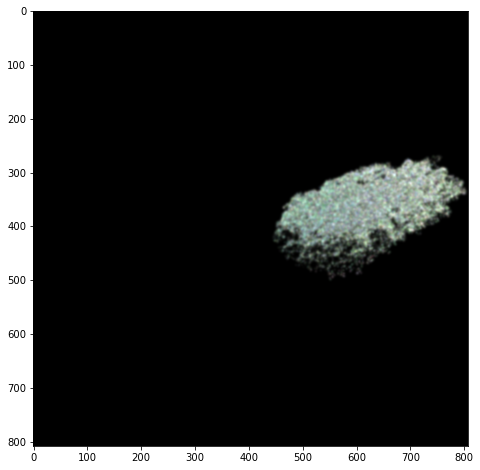

In-Silico Histology Examples - Y-axis


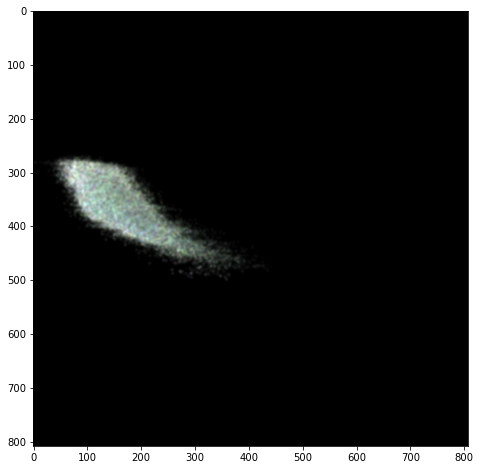

In-Silico Histology Examples - Z-axis


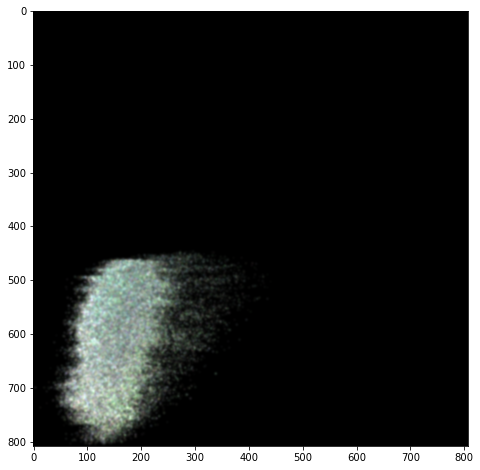

[4, 681.13592004776, tensor([54675000.], grad_fn=<AddBackward0>)]
In-Silico Histology Examples - X-axis


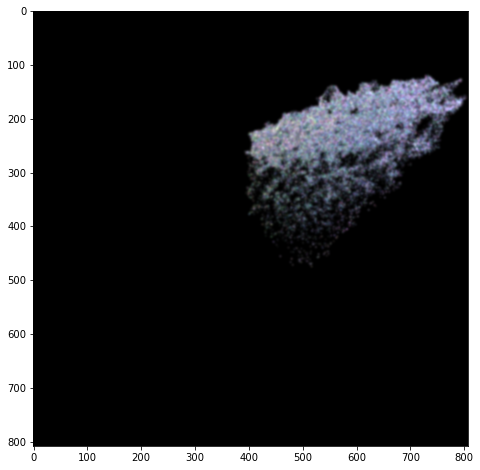

In-Silico Histology Examples - Y-axis


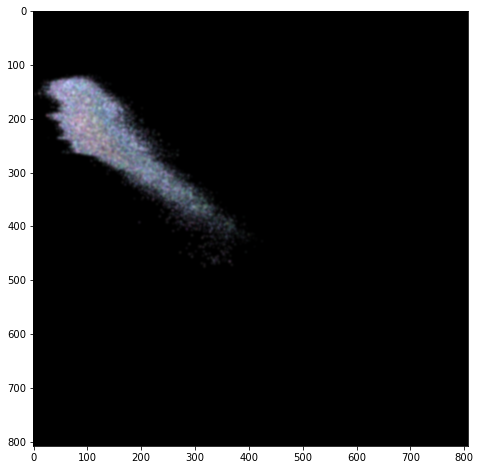

In-Silico Histology Examples - Z-axis


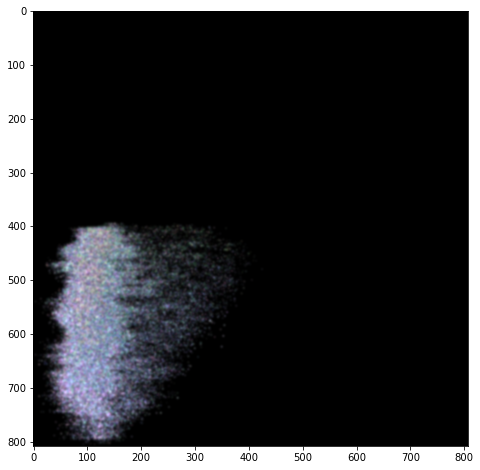

[9, 1362.5275220870972, tensor([17450640.], grad_fn=<AddBackward0>)]
Finished Training


In [13]:
plt.rcParams['figure.figsize'] = (8, 8)
            
import time
import gc

start = time.time()

for epoch in range(10):  # loop over the dataset multiple times

    optimizer.zero_grad()
    grid_return_list, ST_list, spatial_gex_list = net(x_list, gex_list,pixel_list)
    
    
    
# Initialise loss


    loss = torch.zeros(1).to(device)
    

        
    x1 = grid_return_list[0][0]
    x2 = grid_return_list[0][1]
    for i in range(1,len(grid_return_list)):
    
    
    
# Loss function questions how accurate are cell distributions compared to training?


        loss += mseloss(grid_return_list[i][0][:,:2],GRID_list[i-1])
        
        x1 = torch.vstack((x1,grid_return_list[i][0]))
        x2 = torch.vstack((x2,grid_return_list[i][1]))

        
# Loss function questions whether the parameters for the new cell locations are actual signals?

    loss += mseloss(x1,x2)
    
    
    
# Loss function questions whether gene to pixel transformations are learned correctly?


    for i in range(len(gex_list)):
        loss += mseloss(gex_list[i],spatial_gex_list[i][0])+mseloss(gex_list[i],spatial_gex_list[i][1])


        
# Loss function questions whether pixel image prediction is aligned with reality on a:
# local predicted imaging spot level?


    for i in range(len(pixel_list)):
        loss += mseloss(pixel_list[i],ST_list[i+1][0])
    

    
    
    kde_grid_new = []
    cell_grid_new = []
    cell_prob_new = []
    for i in range(len(grid_return_list)):
        kde_grid_new += [[(to_kde_grid(M_list[i],(grid_return_list[i][0][:,:2].cpu().detach().numpy()),main_axis_size))]]        
        x_list[i] = 0.8*x_list[i] + 0.2*to_samples(kde_grid_new[i][0],(grid_return_list[i][0][:,:2].cpu().detach().numpy()),w_size=window_size,type_data="tensor",modality="scMAP")
            
        
        
# Loss function questions whether pixel image prediction is aligned with reality on a:
# global predicted imaging tissue level?

        if i>0:
        
            main_histology = np.max((kde_grid_new[i][0].reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            main_histology = (main_histology-np.min(main_histology))/np.max(main_histology-np.min(main_histology))

            loss += mseloss(torch.from_numpy(main_histology).float().to(device),TF.resize(torch.from_numpy(main_pixel_list[i-1]).permute([2,0,1]),((main_axis_size+4*window_size),(main_axis_size+4*window_size))).permute([1,2,0]))
                    
        if i == 0 and epoch%5==4:
            
            x = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[0,1]].cpu().detach().numpy()),main_axis_size))
            y = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[0,2]].cpu().detach().numpy()),main_axis_size))
            z = (to_kde_grid(M_list[i],(grid_return_list[i][0][:,[1,2]].cpu().detach().numpy()),main_axis_size))

            image_x = np.max((x.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            image_x = (image_x-np.min(image_x))/np.max(image_x-np.min(image_x))
            
            image_y = np.max((y.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            image_y = (image_y-np.min(image_y))/np.max(image_y-np.min(image_y))
            
            image_z = np.max((z.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
            image_z = (image_z-np.min(image_z))/np.max(image_z-np.min(image_z))

            print("In-Silico Histology Examples - X-axis")
            plt.imshow(image_x)
            plt.show()
            
            print("In-Silico Histology Examples - Y-axis")
            plt.imshow(image_y)
            plt.show()
            
            print("In-Silico Histology Examples - Z-axis")
            plt.imshow(image_z)
            plt.show()
                
        else:
            
            
            
# Loss function questions whether the movement of cells around fits well with the idea of Waddington's marble analogy?


            loss += mseloss(x_list[i],to_samples(kde_grid_new[i][0],(grid_return_list[i][0][:,:2].cpu().detach().numpy()),w_size=window_size,type_data="tensor",modality="scMAP"))
            
        
        
    del grid_return_list, ST_list, spatial_gex_list 
    gc.collect()
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    if epoch%5==4:
        print([epoch,end - start,loss])

print('Finished Training')


In [14]:
PATH1 = "/home/jupyter/lmform_analysis/base_cnn/state_dict_VisualForm.pt"
PATH2 = "/home/jupyter/lmform_analysis/base_cnn/to_train_VisualForm.pt"
PATH3 = "/home/jupyter/lmform_analysis/base_cnn/all_VisualForm.pt"

torch.save(net.state_dict(), PATH1)
torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
}, PATH2)
torch.save(net, PATH3)


In [47]:

grid_return_list, ST_list, spatial_gex_list = net(x_list,gex_list,pixel_list)
    
    
for i in range(len(GRID_list)):
    grid_return_list[i+1][0][:,:2] = GRID_list[i]
    
main_axis_size = 300
    
kde_grid_new_x = []
kde_grid_new_y = []
kde_grid_new_z = []


for i in range(len(grid_return_list)):
    kde_grid_new_x += [[to_kde_grid(M_list[i],grid_return_list[i][0].cpu().detach().numpy()[:,[0,1]],main_axis_size)]]
    kde_grid_new_y += [[to_kde_grid(M_list[i],grid_return_list[i][0].cpu().detach().numpy()[:,[1,2]],main_axis_size)]]
    kde_grid_new_z += [[to_kde_grid(M_list[i],grid_return_list[i][0].cpu().detach().numpy()[:,[0,2]],main_axis_size)]]



In-Silico Histology Examples
X-axis


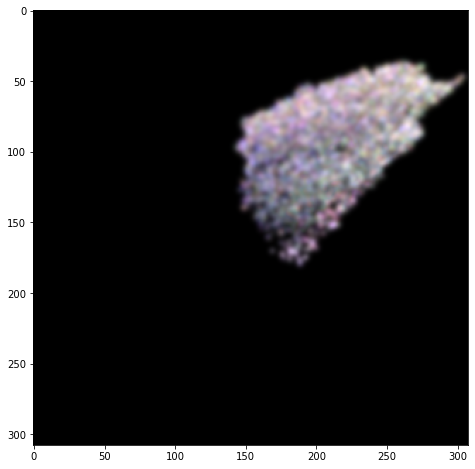

Y-axis


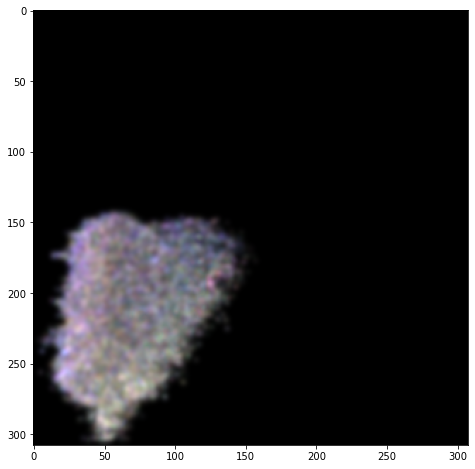

Z-axis


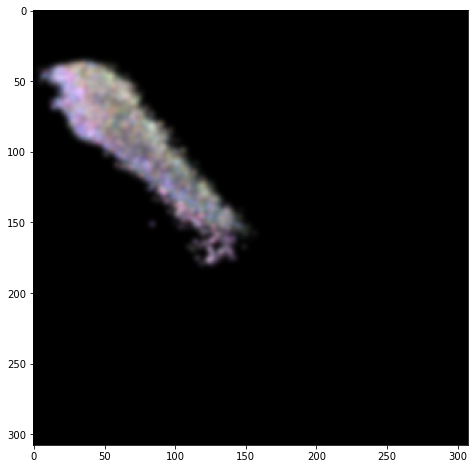

Real Histology Examples
X-axis


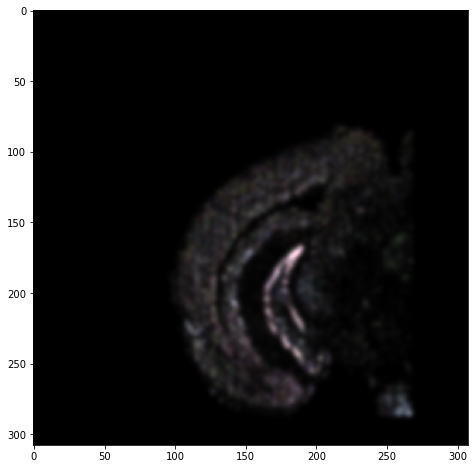

Y-axis


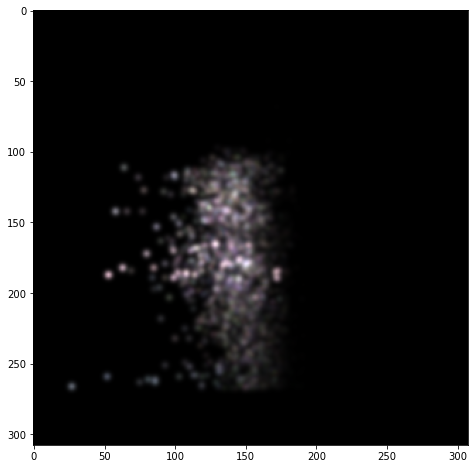

Z-axis


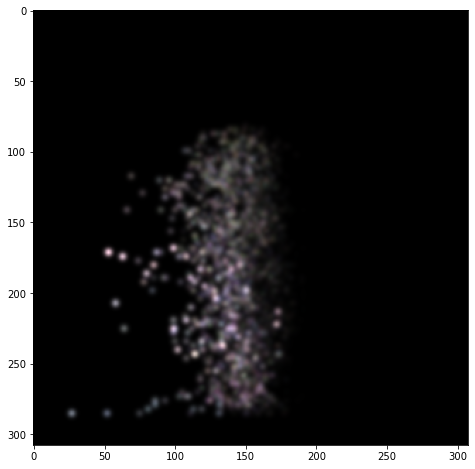

Real Histology Examples
X-axis


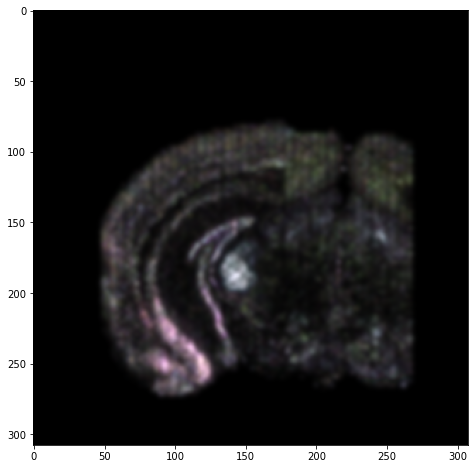

Y-axis


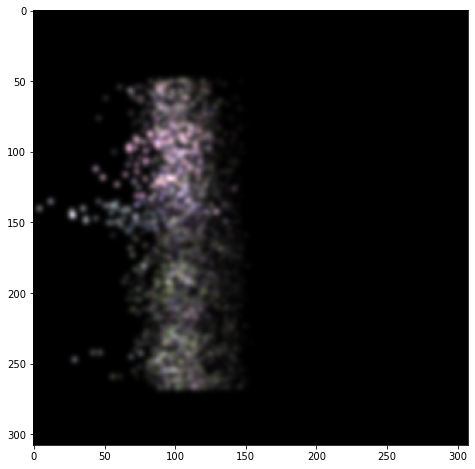

Z-axis


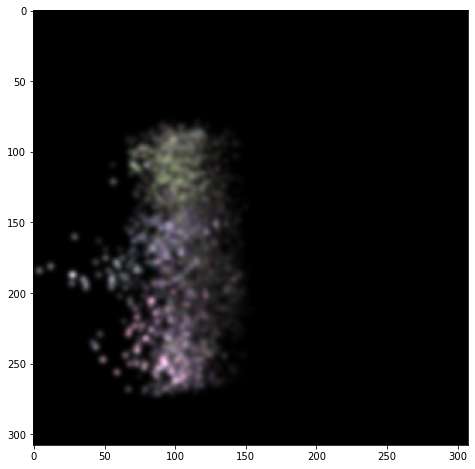

Real Histology Examples
X-axis


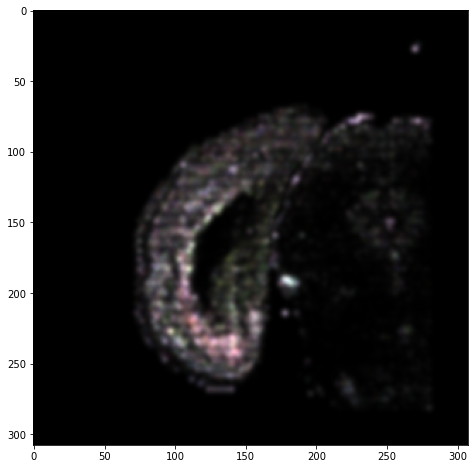

Y-axis


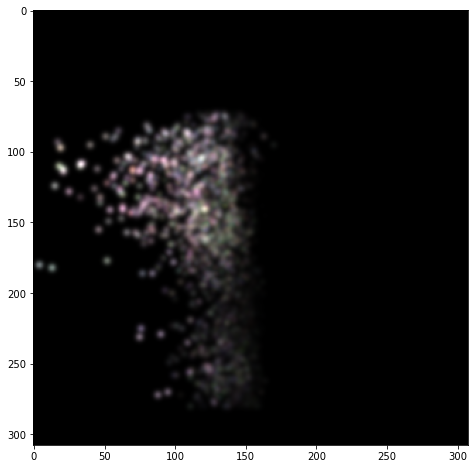

Z-axis


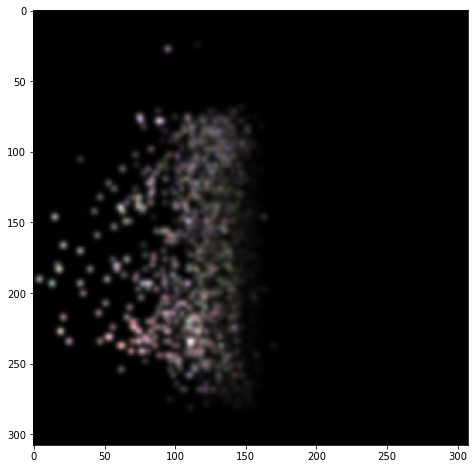

Real Histology Examples
X-axis


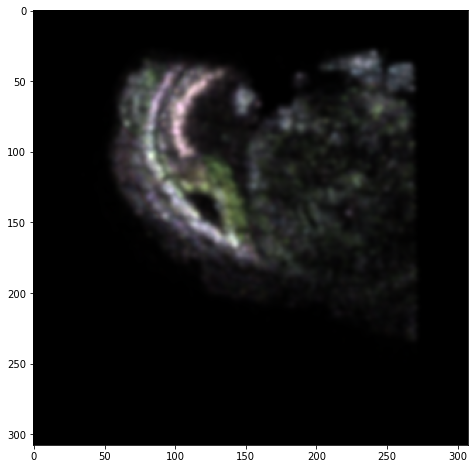

Y-axis


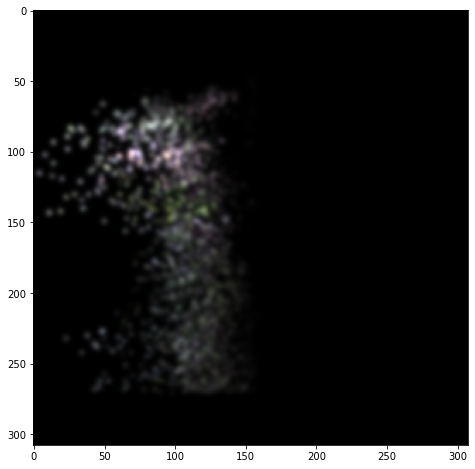

Z-axis


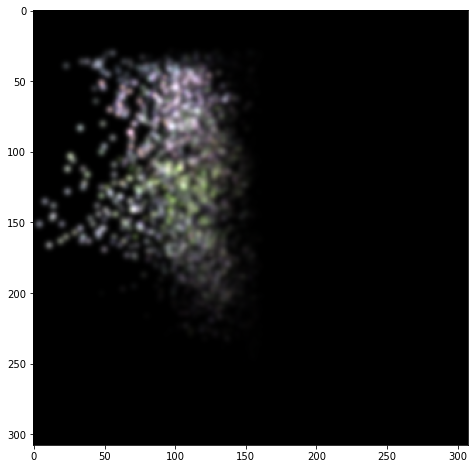

In [48]:
plt.rcParams['figure.figsize'] = (8, 8)

    
for i in range(5):

    x = kde_grid_new_x[i][0]
    y = kde_grid_new_y[i][0]
    z = kde_grid_new_z[i][0]
    
    image_x = np.max((x.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
    image_x = (image_x-np.min(image_x))/np.max(image_x-np.min(image_x))

    image_y = np.max((y.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
    image_y = (image_y-np.min(image_y))/np.max(image_y-np.min(image_y))

    image_z = np.max((z.reshape([(main_axis_size+4*window_size)*(main_axis_size+4*window_size),len(genes)])@((spatial_gex_list[0][2].T).cpu().detach().numpy())).reshape([(main_axis_size+4*window_size),(main_axis_size+4*window_size),32,32,3]),(2,3))
    image_z = (image_z-np.min(image_z))/np.max(image_z-np.min(image_z))


    if i == 0:
        print("In-Silico Histology Examples")
        
    if i > 0:
        print("Real Histology Examples")
        
        
    print("X-axis")
    plt.imshow(image_x)
    plt.show()

    print("Y-axis")
    plt.imshow(image_y)
    plt.show()

    print("Z-axis")
    plt.imshow(image_z)
    plt.show()




In [ ]:

print("Plotting in-silico ST data via loss function optimisation through learning proper gene to pixel transformations and cell placement via KNN gene convolutions")
for i in range(len(genes)):
    
    plt.rcParams['figure.figsize'] = (14, 14)

    fig, axs = plt.subplots(4,3)

    fig.suptitle("Real GEX      " + genes[i])

    axs[0,0].imshow(kde_grid_new_x[1][0][:,:,i])
    axs[0,1].imshow(kde_grid_new_y[1][0][:,:,i])
    axs[0,2].imshow(kde_grid_new_z[1][0][:,:,i])

    axs[1,0].imshow(kde_grid_new_x[2][0][:,:,i])
    axs[1,1].imshow(kde_grid_new_y[2][0][:,:,i])
    axs[1,2].imshow(kde_grid_new_z[2][0][:,:,i])

    axs[2,0].imshow(kde_grid_new_x[3][0][:,:,i])
    axs[2,1].imshow(kde_grid_new_y[3][0][:,:,i])
    axs[2,2].imshow(kde_grid_new_z[3][0][:,:,i])

    axs[3,0].imshow(kde_grid_new_x[4][0][:,:,i])
    axs[3,1].imshow(kde_grid_new_y[4][0][:,:,i])
    axs[3,2].imshow(kde_grid_new_z[4][0][:,:,i])

    axs[0,0].axis('off')
    axs[0,1].axis('off')
    axs[0,2].axis('off')

    axs[1,0].axis('off')
    axs[1,1].axis('off')
    axs[1,2].axis('off')

    axs[2,0].axis('off')
    axs[2,1].axis('off')
    axs[2,2].axis('off')

    axs[3,0].axis('off')
    axs[3,1].axis('off')
    axs[3,2].axis('off')

    
    

    plt.rcParams['figure.figsize'] = (14, 5)

    fig, axs = plt.subplots(1,3)

    fig.suptitle("In-Silico GEX - X-Y-Z-axis     " + genes[i])

    axs[0].imshow(kde_grid_new_x[0][0][:,:,i])
    axs[1].imshow(kde_grid_new_y[0][0][:,:,i])
    axs[2].imshow(kde_grid_new_z[0][0][:,:,i])

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
